# LLM judge
เราจะทำโดยการนำข้อมุลทีทำการ embedding มาให้ LLM ในการตอบ
เเล้วจากนั้นเราจะใช้ LLM มาตรวจสอบว่ามันได้คะเเนนเท่าไหร่เมื่อเทียบกับคำตอบจริง

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


ใช้โมเดล paraphrase-multilingual-mpnet-base-v2

In [ ]:
import requests
import time
import json
import os

# 🔑 API Key สำหรับ Together
api_key = "tgp_v1_LXgDAG8aW34FbMfCN4zs9Hmdl7hQNz0Ewb-PO5obx1E"  # 👈 ใส่ Together API Key ของคุณตรงนี้

# 🚀 โหลดไฟล์คำถามพร้อม RAG Recommendations
input_file = '/content/drive/MyDrive/LockLearn/evaluation_rag_results_v2_SBERT_K=10.json'
output_file = '/content/drive/MyDrive/LockLearn/optimized_answers_Llama4_scout SBERT.json'

# 📂 โหลดข้อมูลจากไฟล์
with open(input_file, 'r', encoding='utf-8') as f:
    data = json.load(f)

# 🚀 โหลดผลลัพธ์ล่าสุด (ถ้ามี)
if os.path.exists(output_file):
    with open(output_file, 'r', encoding='utf-8') as f:
        processed_answers = json.load(f)
        processed_ids = set([item['question'] for item in processed_answers])
else:
    processed_answers = []
    processed_ids = set()

# 🔁 ฟังก์ชันเรียก API พร้อม retry และ timeout ลดลง
def request_with_retry(json_data, retries=3, delay=5):
    headers = {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {api_key}"
    }

    for attempt in range(retries):
        try:
            response = requests.post(
                "https://api.together.xyz/v1/chat/completions",
                headers=headers,
                json=json_data,
                timeout=15  # ลด timeout ลงเหลือ 15 วินาที
            )
            if response.status_code == 200:
                answer = response.json()["choices"][0]["message"]["content"].strip()
                if len(answer) > 20:  # ตรวจสอบความยาวคำตอบ
                    return answer
            print(f"❌ Error (Status {response.status_code}): {response.text}")
            time.sleep(delay)
        except requests.exceptions.RequestException as e:
            print(f"❌ Connection Error: {e}")
            time.sleep(delay)
    return ""

# 🚀 ประมวลผลคำถามที่ยังไม่ได้ตอบ
for item in data:
    if item['question'] in processed_ids:
        continue

    prompt = (
        f"Question: {item['question']}\n"
        f"Recommendations:\n"
    )
    for rec in item.get('recommendations', []):
        prompt += f"- {rec}\n"

    prompt += """

Please generate a supportive, practical, and encouraging response based on the suggestions above.
Respond in the **same language** as the user's question:
- Thai if the question is in Thai.
- English if the question is in English.

Make your answer concise and natural, like a caring life coach giving motivation in just 2-3 sentences. Keep it positive and uplifting.

"""

    json_data = {
        "model": "meta-llama/llama-4-scout-17b-16e-instruct",
        "messages": [{"role": "user", "content": prompt}]
    }

    answer = request_with_retry(json_data)

    if answer:
        processed_answers.append({
            "question": item['question'],
            "answer": answer,
            "category": item.get('category', '')
        })
        processed_ids.add(item['question'])

        # 💾 บันทึกผลลัพธ์ทันที
        with open(output_file, 'w', encoding='utf-8') as f:
            json.dump(processed_answers, f, ensure_ascii=False, indent=4)

        print(f"✅ บันทึกคำตอบล่าสุด ({len(processed_answers)})")

print("✅ เสร็จสิ้นการประมวลผล")

In [ ]:
import json
import requests
import time

api_key = "tgp_v1_5jt9Vq3S7zUxuoY--2rmrzvziTcl-1cWw8p8Yaetb8w"  # แทนด้วย API Key ของคุณ

llm_answers_file = '/content/drive/MyDrive/LockLearn/optimized_answers_Llama4_scout SBERT.json'
ground_truth_file = '/content/drive/MyDrive/LockLearn/evaluation_datasetv2.json'
judgement_output_file = '/content/drive/MyDrive/LockLearn/llm_judgement_scores2.json'

# โหลดคำตอบ
with open(llm_answers_file, 'r', encoding='utf-8') as f:
    llm_answers = json.load(f)

with open(ground_truth_file, 'r', encoding='utf-8') as f:
    ground_truth_data = json.load(f)

# แปลงเป็น dict สำหรับค้นหาง่าย
gt_dict = {item['question']: item['answer'] for item in ground_truth_data}

# ฟังก์ชันส่ง prompt
def request_with_retry(json_data, retries=3, delay=10):
    headers = {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {api_key}"
    }

    for attempt in range(retries):
        try:
            response = requests.post(
                "https://api.together.xyz/v1/chat/completions",
                headers=headers,
                json=json_data,
                timeout=30
            )
            if response.status_code == 200:
                return response.json()["choices"][0]["message"]["content"].strip()
            time.sleep(delay)
        except requests.exceptions.RequestException as e:
            time.sleep(delay)
    return ""

# ประเมินคำตอบทั้งหมด
results = []
for idx, item in enumerate(llm_answers, start=1):
    question = item['question']
    llm_answer = item['answer']
    gt_answer = gt_dict.get(question)

    if not gt_answer:
        continue

    prompt = f"""
Please act as an unbiased evaluator and compare the following two answers:

Question: {question}

Ground Truth Answer: {gt_answer}

LLM-Generated Answer: {llm_answer}

Evaluate the LLM-generated answer against the ground truth based on the following criteria:
- Relevance to the question
- Alignment with the key ideas of the ground truth
- Supportiveness and tone

Give a score between 1 to 5:
- 5 = Almost identical and very supportive
- 4 = Mostly correct and supportive with minor issues
- 3 = Somewhat relevant but missing key points
- 2 = Weak or incorrect in key areas
- 1 = Irrelevant or misleading

Respond with a score and a short explanation (1–2 sentences only).
"""

    json_data = {
        "model": "meta-llama/llama-4-scout-17b-16e-instruct",
        "messages": [{"role": "user", "content": prompt}]
    }

    evaluation = request_with_retry(json_data)

    print(f"✅ ข้อที่ {len(results)+1}: ได้รับการประเมินแล้ว")

    results.append({
        "question": question,
        "llm_answer": llm_answer,
        "ground_truth": gt_answer,
        "evaluation": evaluation
    })

    # บันทึกผลลัพธ์ทันที
    with open(judgement_output_file, 'w', encoding='utf-8') as f:
        json.dump(results, f, ensure_ascii=False, indent=4)

print(f"✅ เสร็จสิ้นการประเมินทั้งหมด {len(results)} ข้อ")


คะแนนรวม:
คะแนน 1: 0
คะแนน 2: 61
คะแนน 3: 163
คะแนน 4: 1130
คะแนน 5: 15


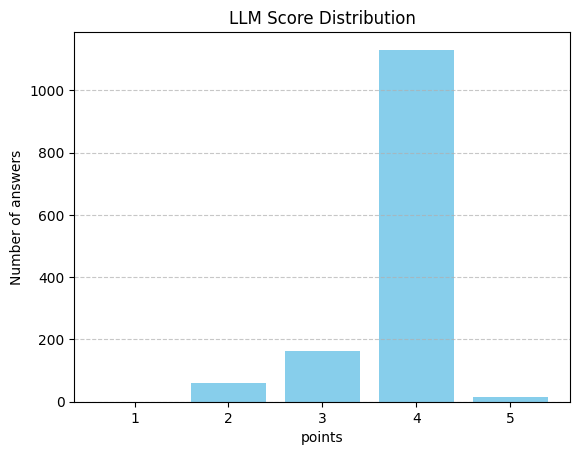

In [2]:
import json
import re
import matplotlib.pyplot as plt

judgement_file =  '/content/drive/MyDrive/LockLearn/llm_judgement_scores2.json'

# โหลดข้อมูล
with open(judgement_file, 'r', encoding='utf-8') as f:
    data = json.load(f)

# นับคะแนน
score_counts = {1: 0, 2: 0, 3: 0, 4: 0, 5: 0}
score_pattern = re.compile(r"\b([1-5])\b")

for item in data:
    evaluation = item['evaluation']
    match = score_pattern.search(evaluation)
    if match:
        score = int(match.group(1))
        if score in score_counts:
            score_counts[score] += 1

# แสดงผลรวมแต่ละคะแนน
print("คะแนนรวม:")
for score in range(1, 6):
    print(f"คะแนน {score}: {score_counts[score]}")

# พล็อตกราฟ
plt.bar(score_counts.keys(), score_counts.values(), color='skyblue')
plt.xlabel('points')
plt.ylabel('Number of answers')
plt.title('LLM Score Distribution')
plt.xticks([1, 2, 3, 4, 5])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
